# CS:GO Analytics Part 2: AWP Battlegrounds
In the first two posts in the series, we learned a little more about the money, the timing, and the bias of Dust2. In the next three posts, we analyse areas in Dust2 where most blood was shed by both the Ts and CTs for AWPs, rifles (AK47, M4A4, M4A1), and grenades. We begin with everyone's favourite weapon: the AWP.  
  
## About the AWP
AWP stands for Arctic Warfare Police, although the weapon skin in CS:GO was based on the Arctic Warfare Magnum variant. One bullet from the AWP delivers an instant kill, unless it hits a player's leg or is cushioned by an obstacle (e.g. door, wall, another player's head). This makes the AWP extremely deadly. However, as a bolt action rifle, it can only fire 1 bullet before requiring a reload, which means AWPers need to take cover after firing.  
  
## Framework for Analysis
In this post, we analyse Terrorist (T) and Counter-Terrorist (CT) AWP angles on Dust2 **prior to planting of the bomb**. We select this subset of shot data because this is when the bulk of shots are taken. Retaking bomb sites are not worth analysing because (1) we don't have data on where the bomb is planted (this affects how CTs strategise) and (2) the angles are likely to be similar to those of Ts attacking and CTs defending the bomb sites.  
  
In this subset of pre-plant (before the bomb plant) AWP shots from the [CS:GO Competitive Matchmaking Dataset on Kaggle](https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage), each sample captures a successful shot that ranges from 1 to 100 in damage, and is tagged with details of the attackers and victims. Examples of details include their map coordinates and weapons used, team name, and side (T/CT).  
  
We begin with an overview of **Hotspots**: locations where players get hit the most. Next, we analyse **AWP Battlegrounds**: the most hotly-contested angles on the map. Finally, we end with a summary of the angles that favour either of the two sides.  

# Orientation of Dust2
To understand the insights in this post, we'll need a quick orientation of the map. We will be using the location callouts from this excellent guide from [ClutchRound](http://clutchround.com/):  
  
<img src="../img/csgo_orientation.png" width="800">

In [1]:
# Import required packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from matplotlib import collections as mc
from matplotlib.lines import Line2D
from scipy.misc import imread
from scipy.stats import mannwhitneyu
from sklearn.cluster import KMeans

# Settings
warnings.filterwarnings('ignore')

In [2]:
# Modify settings
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rcParams['grid.color'] = '#e8e8e8'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.color'] = '#494949'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.color'] = '#494949'
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.edgecolor'] = '#494949'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelpad'] = 15
mpl.rcParams['axes.labelcolor'] = '#494949'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.sans-serif'] = 'Raleway'
mpl.rcParams['scatter.marker'] = 'h'

# Title parameters
fontdict = {'fontweight': 'bold', 'fontsize':20}

# Colours
def get_cols():
    
    print('[Colours]:')
    print('Orange:     #ff9966')
    print('Navy Blue:  #133056')
    print('Light Blue: #b1ceeb')
    print('Green:      #6fceb0')
    print('Red:        #f85b74')

    return

In [3]:
# Load data
dmg_data = pd.read_csv('../esea_dust2_dmg.csv')

# Configure Dust2 map parameters
resX = 1024
resY = 1024
startX = -2486
startY = -1150
endX = 2127
endY = 3455
distX = endX - startX
distY = endY - startY

# Convert distance data
dmg_data['attx'] = (dmg_data.att_pos_x * 1.01 - startX) / (distX) * resX
dmg_data['vicx'] = (dmg_data.vic_pos_x * 1.01 - startX) / (distX) * resX
dmg_data['atty'] = (dmg_data.att_pos_y * 1.01 - startY) / (distY) * resY
dmg_data['vicy'] = (dmg_data.vic_pos_y * 1.01 - startY) / (distY) * resY

# Extract AWP data
df_awp = dmg_data[['attx', 'atty', 'vicx', 'vicy', 'att_side', 'hp_dmg']][(dmg_data.wp=='AWP') & 
                                                                                 (~dmg_data.is_bomb_planted)].copy()

# Extract T and CT data
awpt = df_awp[df_awp.att_side == 'Terrorist']
awpct = df_awp[df_awp.att_side == 'CounterTerrorist']

# Hotspots
First, we begin with locations that you should avoid if you don't want to get picked off by an AWPer. The most common areas for getting shot are:  
  
1. **CT Mid vs. T Spawn:** Ts typically take shots from T Spawn to CT Mid. CTs making the cross from CT Spawn to B typically get caught, but occasionally, the Ts get hit.
2. **Tunnels Exit:** Ts making their way into B Site through Tunnels Exit are sitting ducks for CTs sniping from B Platform. Also note the angle that Ts take from inside Tunnels to snipe into B Site (trail of red dots).
3. **B Doors:** CTs guarding B from B Doors get shot from B Site.
4. **Window:** Both Ts and CTs attempt to use Window to get into B.
5. **Mid Doors:** Ts looking to check CT Mid from Mid Doors get picked off by CTs lurking on the other side.
6. **Top Mid and Catwalk:** CTs watching Mid from CT Mid usually catch Ts sniping from Top Mid or moving along Catwalk off guard.
7. **Short Stairs:** Ts making a play on A are often shot on Short Stairs, which can be guarded from A Site.
8. **Long and Long Doors:** CTs holding the Long angle and Ts holding from Long Doors face off very often. We'll see more of this in the next section.
9. **Car:** This is a popular position for CTs to hold from. They can watch Short, Long, and CT Mid.

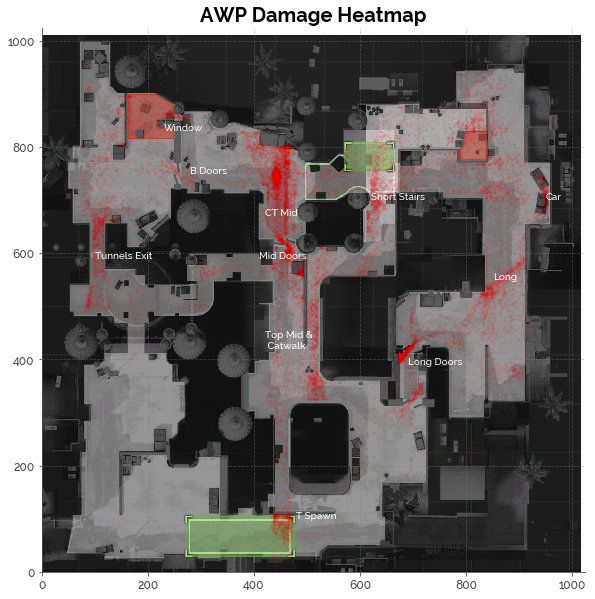

In [4]:
# Read image
map_dust2 = plt.imread('../de_dust2.png')

# Plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.4)
ax.imshow(map_dust2, zorder=0, extent=[0.0, 1015, 0., 1010])
ax.scatter(x=df_awp.vicx, y=df_awp.vicy, color='red', s=2, alpha=0.05)
plt.title('AWP Damage Heatmap', fontdict={'fontweight': 'bold', 'fontsize': 20})
plt.text(100, 590, text='Tunnels Exit', s=10, color='white')
plt.text(280, 750, text='B Doors', s=10, color='white')
plt.text(230, 830, text='Window', s=10, color='white')
plt.text(420, 670, text='CT Mid', s=10, color='white')
plt.text(410, 590, text='Mid Doors', s=10, color='white')
plt.text(620, 700, text='Short Stairs', s=10, color='white')
plt.text(420, 420, text='Top Mid &\n Catwalk', s=10, color='white')
plt.text(690, 390, text='Long Doors', s=10, color='white')
plt.text(850, 550, text='Long', s=10, color='white')
plt.text(950, 700, text='Car', s=10, color='white')
plt.text(480, 100, text='T Spawn', s=10, color='white')
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.show()

While these findings give us a broad sense of the AWP killzones, we don't have an idea where we should stand if we are AWPers ourselves. The next section will shed light on the optimal positions to take as an AWPer.

# AWP Battlegrounds
Now, we dive into the hotly-contested AWP angles on the map. Our objectives are to (1) identify popular AWP angles taken by the Ts and CTs, and (2) evaluate which side (T or CT) these angles favour.  

## Clustering the Data
First, we need to identify the possible angles using cluster analysis. Using K-Means clustering, we group AWP shots into clusters using the coordinates of the attacker and victim. After testing several cluster values using the K-Means algorithm, we chose 20 as the optimal number of clusters for the T and CT data.

In [5]:
# Initialise list to store scores
scores_t = []
scores_ct = []

# Numbers of clusters
num_clusters = [5, 10, 15, 20, 30, 40, 60]

for k in num_clusters:
    cls_t = KMeans(n_clusters=k, n_jobs=4)
    cls_ct = KMeans(n_clusters=k, n_jobs=4)
    cls_t.fit(awpt[['attx', 'atty', 'vicx', 'vicy']])
    cls_ct.fit(awpct[['attx', 'atty', 'vicx', 'vicy']])
    scores_t.append(cls_t.score(awpt[['attx', 'atty', 'vicx', 'vicy']]))
    scores_ct.append(cls_ct.score(awpct[['attx', 'atty', 'vicx', 'vicy']]))

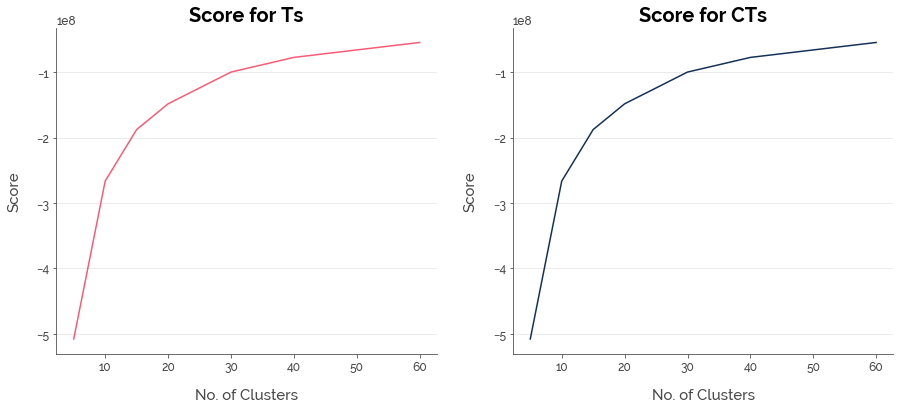

In [6]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(num_clusters, scores_t, color='#f85b74')
ax[0].set_title('Score for Ts', fontdict=fontdict)
ax[0].set_xlabel('No. of Clusters', weight='medium')
ax[0].set_ylabel('Score', weight='medium')

ax[1].plot(num_clusters, scores_t, color='#133056')
ax[1].set_title('Score for CTs', fontdict=fontdict)
ax[1].set_xlabel('No. of Clusters', weight='medium')
ax[1].set_ylabel('Score', weight='medium')

plt.show()

In [7]:
# Fit K-Means model
cls_t = KMeans(n_clusters=20, n_jobs=4, random_state=123)
cls_ct = KMeans(n_clusters=20, n_jobs=4, random_state=123)
cls_t.fit(awpt[['attx', 'atty', 'vicx', 'vicy']])
cls_ct.fit(awpct[['attx', 'atty', 'vicx', 'vicy']])

# Generate labels and append to dataframe
awpt['cluster'] = cls_t.predict(awpt[['attx', 'atty', 'vicx', 'vicy']])
awpct['cluster'] = cls_ct.predict(awpct[['attx', 'atty', 'vicx', 'vicy']])

Looking across the clusters, we see varying numbers of AWP shots taken. But, this does not give us any insights. We must analyse each cluster visually to assign an intuitive label to each cluster.

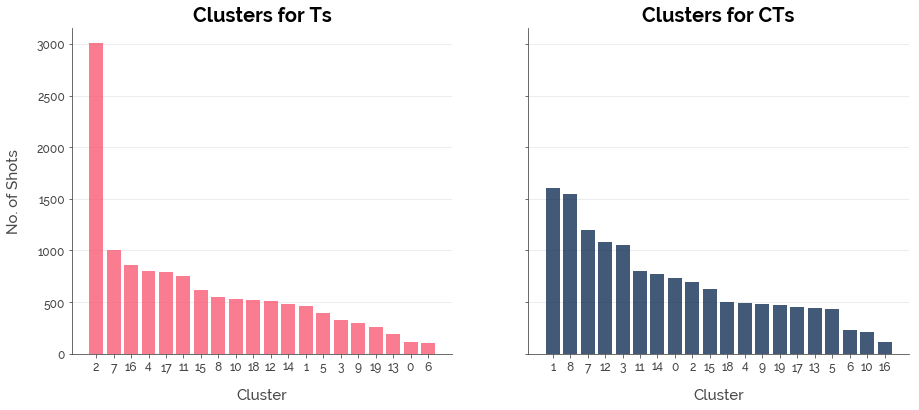

In [8]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)

ax[0].bar(awpt.cluster.value_counts().index.astype(str), awpt.cluster.value_counts(), alpha=0.8, color='#f85b74')
ax[0].set_title('Clusters for Ts', fontdict={'fontweight': 'bold', 'fontsize':20})
ax[0].set_xlabel('Cluster', weight='medium')
ax[0].set_ylabel('No. of Shots', weight='medium')

ax[1].bar(awpct.cluster.value_counts().index.astype(str), awpct.cluster.value_counts(), alpha=0.8, color='#133056')
ax[1].set_title('Clusters for CTs', fontdict={'fontweight': 'bold', 'fontsize':20})
ax[1].set_xlabel('Cluster', weight='medium')

plt.show()

## Evaluation Metrics
  
### Metric 1: Average Shot Damage (AVG Damage)
In our analysis, we use the average damage of shots in each cluster (AVG Damage). A cluster would attain a high score if there were more (1) clean (one-hit kills) and (2) high-damage shots made. Thus, AVG Damage is a measure of **angle effectiveness**. Of course, this metric has its limitations. The data was subject to random factors (e.g player performance, lag, and luck) that could have impacted the results. Hence, we need to assume that these factors will affect the metric systematically **across** clusters, thereby enabling us to make fair comparisons.  
  
### Metric 2: Shot Counts
The shot counts for each cluster can also be used to infer the **positional advantage** for the angles. For example, if Ts landed substantially more shots in a cluster of angles, it means that fewer or no return shots were received from CTs on those angles. Either the Ts had better visibility of their enemies, or the position enabled them to escape without taking return fire.  

***Note:** Each sample involves two players: an attacker and a victim. Therefore, if the victims for a given angle in a specific cluster did indeed return fire consistently, the shot count must have increased in tandem for the victim side. If there were consistently no return shots, the shot count would remain low.*  

## Final Preparations
Finally, before we begin our analysis, here's a helper function for plotting shots from each cluster with our evaluation metrics. It will come in handy when we analyse shots from the other weapons/equipment. The **red/blue dashed lines** represent shots, while the **black dots** represent the positions from which they were taken. The greater the overlap of lines, the more popular the angle.

In [9]:
# Function for plotting cluster
def plot_cluster(clust, df, title, color, trans=0.1):
    
    # Filter data
    cluster_data = df[df.cluster.isin(clust)]

    # Extract coordinates
    cluster_coords = [
        [(cluster_data.attx.iloc[i], cluster_data.atty.iloc[i]),
         (cluster_data.vicx.iloc[i], cluster_data.vicy.iloc[i])] for i in range(cluster_data.shape[0])
    ]
    
    # Extract attacker coordinates
    att_coords = [(cluster_data.attx.iloc[i], cluster_data.atty.iloc[i]) for i in range(cluster_data.shape[0])]
    
    
    # Create line collection
    lc = mc.LineCollection(cluster_coords, colors=color, linewidths=2, linestyle='dotted', alpha = trans)

    # Read image
    map_dust2 = imread('../de_dust2.png')
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.4)
    ax.imshow(map_dust2, zorder=0, extent=[0.0, 1015, 0., 1010])
    ax.add_collection(lc)
    ax.scatter(x=cluster_data.attx, y=cluster_data.atty, color='black', s=3, alpha=0.2)
    plt.title(title, fontdict={'fontweight': 'bold', 'fontsize': 20})
    plt.text(400,980, 'Shots: '+ '{:,}'.format(cluster_data.shape[0]), size=15, color='white')
    plt.text(400,950, 'Dmg per Shot: '+ '{0:.2f}'.format(cluster_data.hp_dmg.mean()), size=15, color='white')
    plt.xlim(0,1024)
    plt.ylim(0,1024)
    plt.show()

## The Middle
We begin the analysis with the most important area: Mid. Mid is an incredibly open area in the center of the map. Controlling Mid enables a team to influence enemy movement. For example, by controlling Mid, Ts can stop CTs crossing from one bombsite to another by sniping through Mid Doors into CT Mid. By controlling Mid, CTs can pick off Ts on Catwalk before they mount an attack on A.  
  
### The Mid Duel
This is probably the most popular angle for AWPers. CTs and Ts both snipe each other from their respective spawn areas through Mid. See the screenshots below for reference.
  
#### Ts Sniping from T-Spawn
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/1_mid_t.jpg" width="800">  
  
#### CTs Sniping from CT Mid
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/1_mid_ct.jpg" width="800">

Comparing the statistics, we see that more shots were taken from T-spawn than from CT Mid. However, the average damage per shot was lower because most shots were cushioned by Mid Doors. Notice how many of the Ts' shots went **through the left door**, which were probably attempts to deal some damage to the CTs as they jumped across CT Mid on their way to B. Meanwhile, the CTs were able to do more damage per shot, arguably because the shots were direct hits **between** Mid Doors, which instantly killed the targets.  
  
Overall, we can conclude that the CT angle sets up more **effective** shots, but the T angle has a **positional** advantage because it enables Ts to deliver damage without return fire. We confirm this with a Mann-Whitney U test.

In [10]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster.isin([2,11])].hp_dmg,
                        awpct[awpct.cluster.isin([3])].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.000


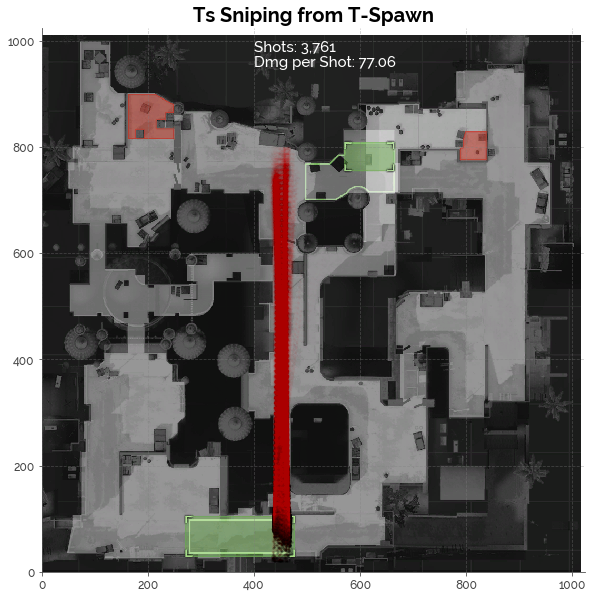

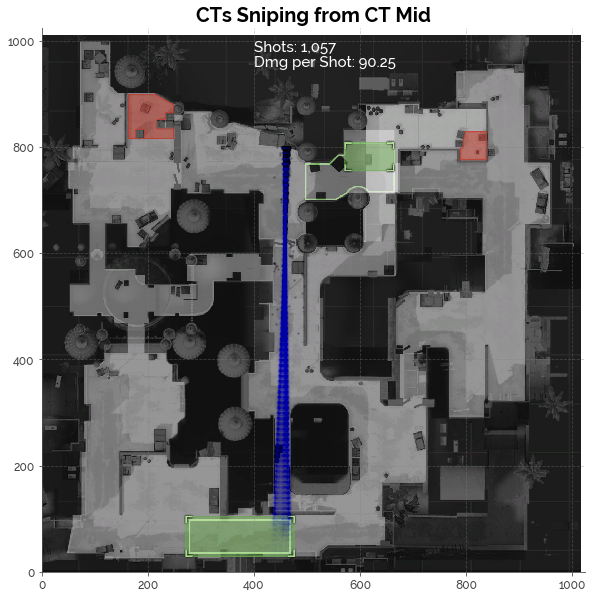

In [11]:
plot_cluster([2, 11], awpt, 'Ts Sniping from T-Spawn', 'red', 0.01)
plot_cluster([3], awpct, 'CTs Sniping from CT Mid', 'blue', 0.01)

### Mid vs. CT Mid
Next, we examine a popular angle in Mid: Top Mid/Catwalk vs. CT Mid. See the screenshots below for reference.
  
#### Ts Sniping from Catwalk
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/2_midwalk_t.jpg" width="800">  
  
#### CTs Sniping from CT Mid
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/2_midwalk_ct.jpg" width="800">  

Clearly, the CT angle is more **effective** and has a **positional** advantage. This conclusion is confirmed with a Mann-Whitney U test. The CT angle is advantageous because Ts have to be on the move when they are on Catwalk. Meanwhile, the CTs hold a static position as they wait for a T to step into their crosshair.

In [12]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster == 17].hp_dmg,
                        awpct[awpct.cluster.isin([1,8])].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.000


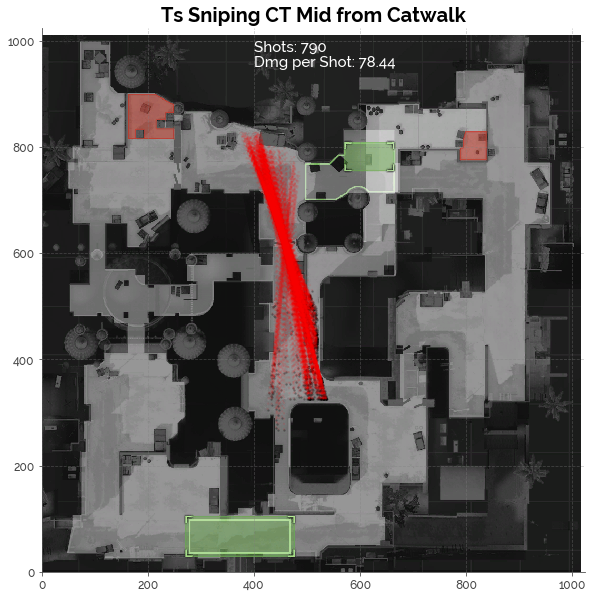

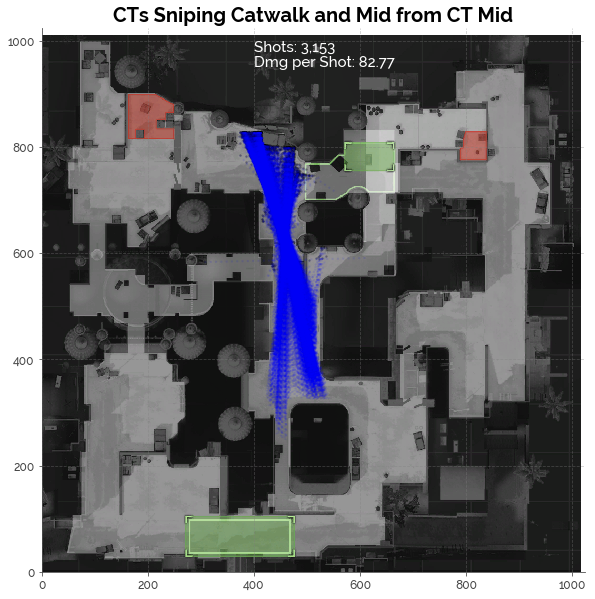

In [13]:
plot_cluster([17], awpt, 'Ts Sniping CT Mid from Catwalk', 'red')
plot_cluster([1, 8], awpct, 'CTs Sniping Catwalk and Mid from CT Mid', 'blue')

## Attacking A: The Long Way
Next, we move on to popular AWP angles along the Ts' route to A through Long. 
  
### The Long Doors Duel
First, the angle from Long Doors to Long for the Ts (and the opposite for the CTs) is an important duel. When both the Ts and CTs have good spawns at the far ends of their spawn points (location they appear at the start of the round), they rush to take up this angle and arrive at almost the same time. That makes this angle extremely competitive.  
  
#### Ts Sniping Long
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/3_alongdoors_t.jpg" width="800">  
  
#### CTs Sniping Long Doors
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/3_alongdoors_ct.jpg" width="800">  

The scores were extremely close on this angle. We can confirm that there was no statistically significant difference:  

In [14]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster == 7].hp_dmg,
                        awpct[awpct.cluster == 7].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.943


Thus, we can say that there was no advantage in **effectiveness** for the Ts and CTs. From a **positional** point of view, we could say that the CTs had an advantage because they were able to land a larger number of shots without return fire.

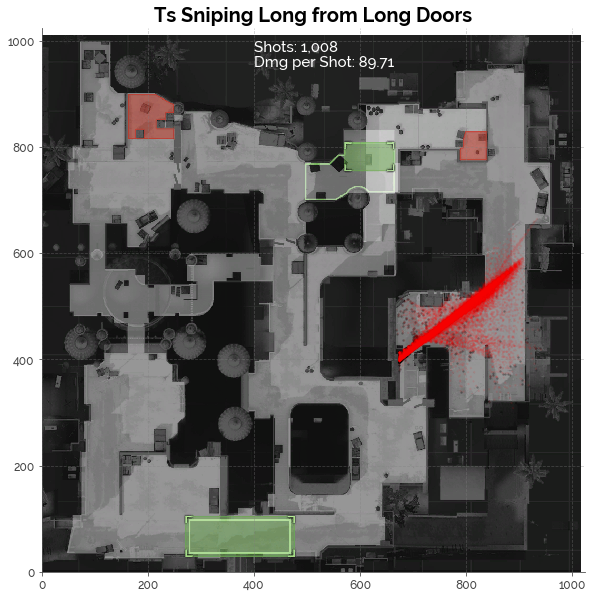

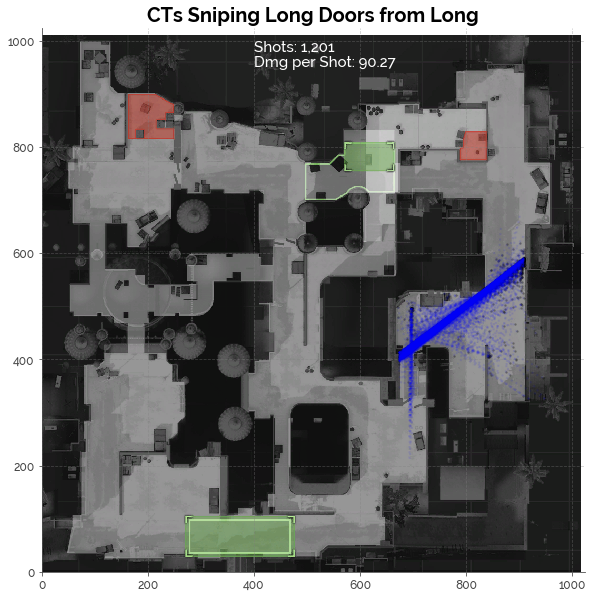

In [15]:
plot_cluster([7], awpt, 'Ts Sniping Long from Long Doors', 'red')
plot_cluster([7], awpct, 'CTs Sniping Long Doors from Long', 'blue')

### The Long Duel: Long vs. A
Assuming the Ts break through Long Doors successfully, they can take up a position from Pit or just outside Pit. Meanwhile, the CTs typically take positions at Car, Cross, and A site.  
  
#### Ts Sniping A Site from Pit
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/4_along_t.jpg" width="800">  
  
#### CTs Sniping Long from A Site
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/4_along_ct.jpg" width="800">  

This angle provided the CTs with both an **effectiveness** and a **positional** advantage. There are advantages for the CTs because the they can hold angles at or slightly off the following positions: (1) Car, (2) Goose, and (3) A Plat. With numerous positions, the probability of catching a T off guard is high.

In [16]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster == 4].hp_dmg,
                        awpct[awpct.cluster.isin([0, 14])].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.000


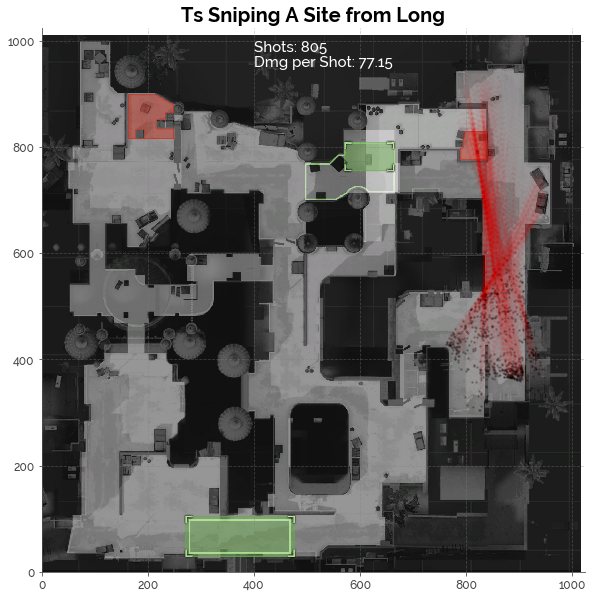

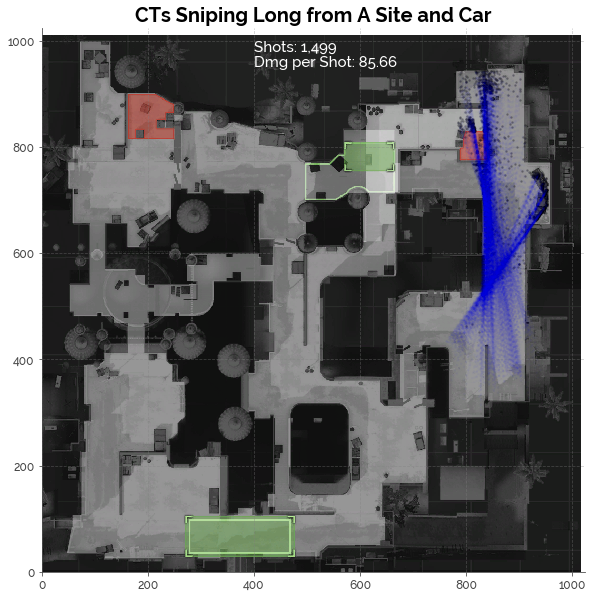

In [17]:
plot_cluster([4], awpt, 'Ts Sniping A Site from Long', 'red', 0.03)
plot_cluster([0, 14], awpct, 'CTs Sniping Long from A Site and Car', 'blue', 0.03)

### Cross vs. CT Mid
Now, assuming the Ts successfully take Long, they still have one more hurdle: Cross. This is where they can be eliminated by CTs sniping from CT Mid or CT Spawn.   
  
#### Ts Sniping CT Mid from Cross
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/5_cross_t.jpg" width="800">  
  
#### CTs Sniping Cross from CT Mid
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/5_cross_ct.jpg" width="800">  

It appears that the Ts had an **effectiveness** advantage over the CTs, assuming that the other angles in the cluster did not create an upward bias in AVG Damage. A **positional** advantage was present probably because the Ts can hide behind the car, which makes it difficult for the CTs to spot them. Meanwhile, the CTs are more easily spotted when they take up positions at CT Mid.

In [18]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster == 10].hp_dmg,
                        awpct[awpct.cluster == 13].hp_dmg,
                        alternative='greater')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg > CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg > CT Dmg
p-value: 0.004


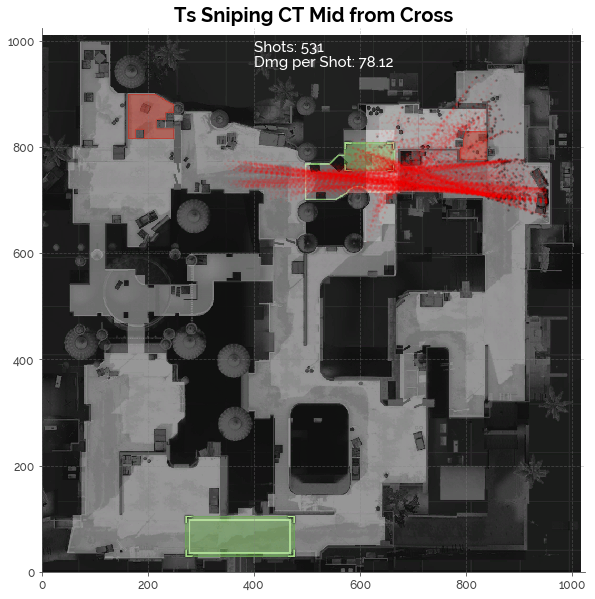

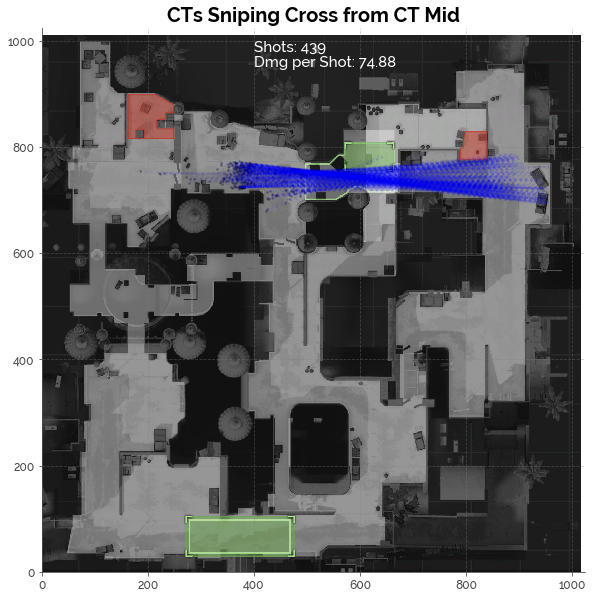

In [19]:
plot_cluster([10], awpt, 'Ts Sniping CT Mid from Cross', 'red')
plot_cluster([13], awpct, 'CTs Sniping Cross from CT Mid', 'blue')

## Attacking A: The Short Way
Next, we jump over to the angles along the route from Mid to A via Catwalk, Short Stairs and Short.

### The Catwalk and Short Stairs Duel
The other sensible way (besides Long) for Ts to attack A is through Catwalk and Short Stairs. At times, CTs might get aggressive and take up forward positions here, and fall back to A Site when they are in trouble.  
  
#### Ts Sniping Catwalk and Short Stairs
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/6_catwalk_t.jpg" width="800">  
  
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/6_short_stairs_t.jpg" width="800">  
  
#### CTs Sniping Cross from CT Mid
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/6_catwalk_ct.jpg" width="800">  
  
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/6_short_stairs_t.jpg" width="800">  

#### Some Data Cleaning
The original clusters were extremely dirty. There were numerous shots from Mid Doors vs. CT Spawn that were muddled with the Catwalk / Short Stairs angles. Hence, we performed a second level of clustering to separate these two groups of angles.

In [20]:
# Extract data
awpt_css = awpt[awpt.cluster == 3]
awpct_css = awpct[awpct.cluster == 4]

cls_t2 = KMeans(n_clusters = 3, random_state=123)
cls_ct2 = KMeans(n_clusters = 2, random_state=123)
awpt_css['cluster'] = cls_t2.fit_predict(awpt_css[['attx', 'atty', 'vicx', 'vicy']])
awpct_css['cluster'] = cls_ct2.fit_predict(awpct_css[['attx', 'atty', 'vicx', 'vicy']])

We can see from the AVG Damage figures that neither the Ts or CTs had a big advantage here. This is confirmed by the Mann-Whitney U Test. However, the Ts have a **positional** advantage, possibly because it is quicker and easier for a T to escape from Catwalk/Short Stairs to Mid than it is for CTs to backtrack into A.  
  
We should note, though, that the sample size is relatively small, which implies that AWPers don't typically hold these angles. This makes sense, because these angles have a very short distance, which reduces the reaction time for scoped-in AWPers, and increases the risk of getting rushed.

In [21]:
# Perform test
u, p_val = mannwhitneyu(awpt_css[awpt_css.cluster.isin([0,1])].hp_dmg,
                        awpct_css[awpct_css.cluster == 0].hp_dmg,
                        alternative='greater')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg > CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg > CT Dmg
p-value: 0.351


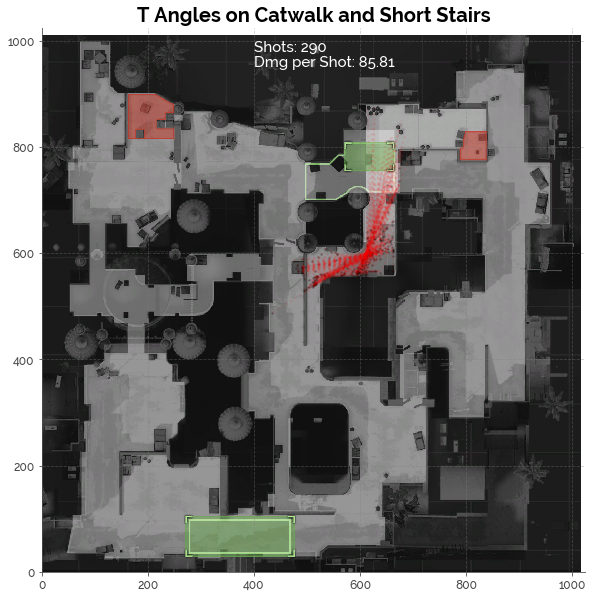

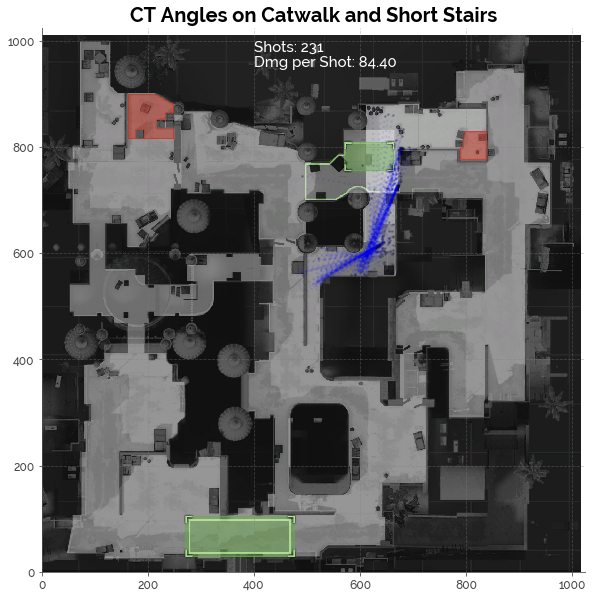

In [22]:
# Plot
plot_cluster([0,1], awpt_css, 'T Angles on Catwalk and Short Stairs', 'red')
plot_cluster([0], awpct_css, 'CT Angles on Catwalk and Short Stairs', 'blue')

### Short vs. A
Clearing Catwalk and Short Stairs is the easy part. At the A site, the CTs have numerous angles to take aim from, which could easily catch the Ts off guard.
  
#### Ts Sniping A Site
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/7_ashort_t.jpg" width="800">  
  
#### CTs Sniping Short
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/7_ashort_ct.jpg" width="800">  

As shown from the plots, there were 5 main angles that the CTs held (and that the Ts had to check): (1) Goose, (2) A Plat, (3) halfway up A Ramp, (4) bottom of A Ramp, and (5) Car. These provided the CTs with a huge **positional** advantage. Meanwhile, the CTs also had a small **effectiveness** advantage, possibly because of the fewer obstructions from the CT angles relative to the T angles.

In [23]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster == 16].hp_dmg,
                        awpct[awpct.cluster.isin([12,15])].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.038


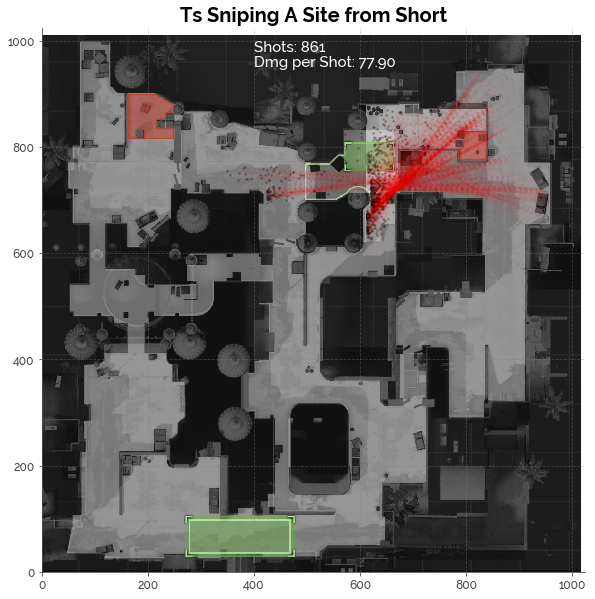

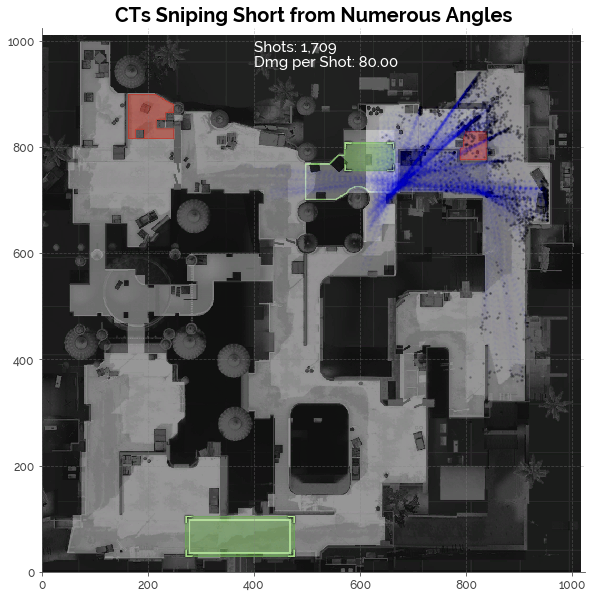

In [24]:
plot_cluster([16], awpt, 'Ts Sniping A Site from Short', 'red', 0.05)
plot_cluster([12, 15], awpct, 'CTs Sniping Short from Numerous Angles', 'blue', 0.02)

## Attacking B Through Tunnels
Finally, we examine the angles along the way to B, starting with the route through Tunnels.
  
### The Death Trap - Tunnels Exit vs. Back Plat
To enter B, Ts need to traverse the Tunnels Exit. Along the narrow tunnel into B, the Ts are sitting ducks for CTs sniping from Back Plat.  
  
#### Ts Sniping Back Plat / Back Site
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/8_tunnels_t.jpg" width="800">  
  
#### CTs Sniping Tunnels Exit
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/8_tunnels_ct.jpg" width="800">  

As expected, we see that the CTs had **effectiveness** and **positional** advantages from this angle. The high effectiveness score from the CTs suggests a large proportion of clean, one-hit kills.

In [25]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster == 16].hp_dmg,
                        awpct[awpct.cluster.isin([12,15])].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.038


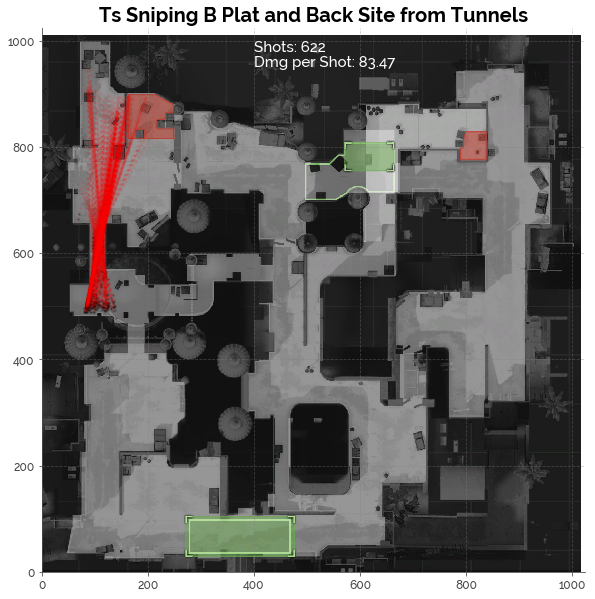

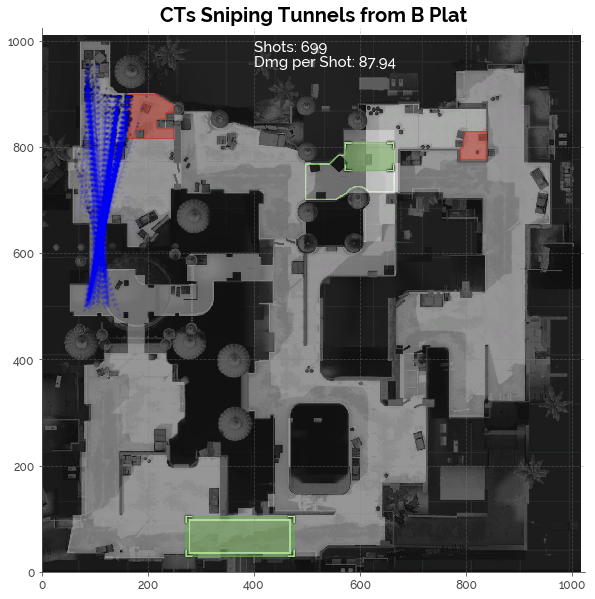

In [26]:
plot_cluster([15], awpt, 'Ts Sniping B Plat and Back Site from Tunnels', 'red')
plot_cluster([2], awpct, 'CTs Sniping Tunnels from B Plat', 'blue')

### The Death Trap II: Tunnels Exit vs. B
Assuming the Ts make it through Tunnels Exit, they have yet another death trap in the form of the numerous angles inside B. These characteristics make B a difficult site to take, and an easy site to defend.  
  
#### Ts Sniping B Site
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/9_inside_b_t.jpg" width="800">  
  
#### CTs Sniping Tunnels Exit
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/9_inside_b_ct.jpg" width="800">  

This cluster of angles is extremely similar in characteristics to the Short vs. A cluster. The CTs had approximately 5 main angles among a large number of obstructions, as well as a clear view of Tunnels Exit. This made them more **effective** and provided them with a **positional** advantage.

In [27]:
# Perform test
u, p_val = mannwhitneyu(awpt[awpt.cluster == 1].hp_dmg,
                        awpct[awpct.cluster.isin([11])].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.000


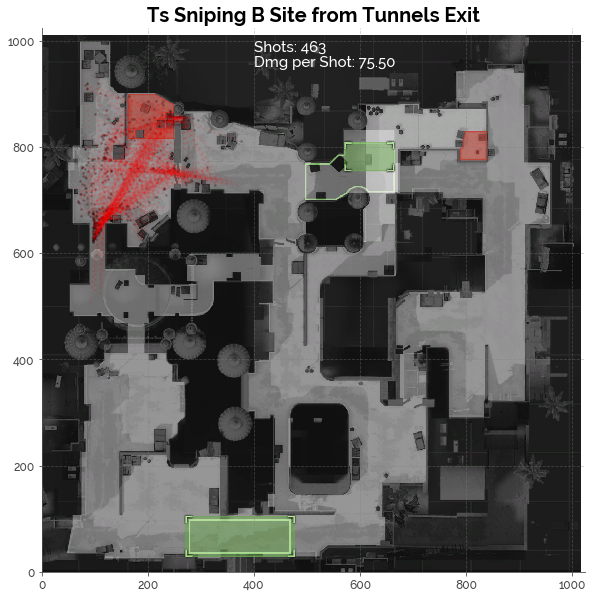

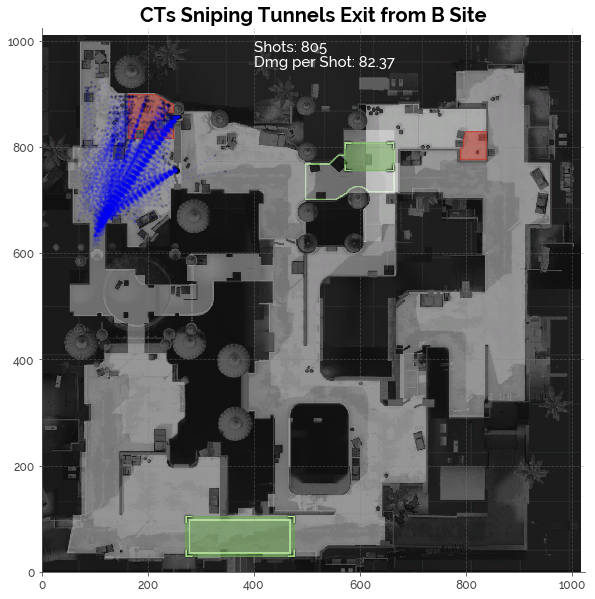

In [28]:
plot_cluster([1], awpt, 'Ts Sniping B Site from Tunnels Exit', 'red')
plot_cluster([11], awpct, 'CTs Sniping Tunnels Exit from B Site', 'blue')

## Attacking B Through Mid - CT Mid vs. B
Even if the Ts clear Mid Doors, they still have a major hurdle to clear: CT Mid. Although this area is relatively open, there are only 2-3 angles to watch out for.
  
#### Ts Sniping Window / B Doors
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/10_b_doors_t.jpg" width="800">  
  
#### CTs Sniping CT Mid
<img src="https://raw.githubusercontent.com/chrischow/dataandstuff/gh-pages/graphics/2019-04-14-csgo-analytics-part-2-awp-battlegrounds/10_b_doors_ct.jpg" width="800">  

#### Data Cleaning
Once again, some data cleaning was required to sanitise the clusters.

In [29]:
# Extract data
awpt_btm = awpt[awpt.cluster == 5]
awpct_btm = awpct[awpct.cluster == 17]

cls_t3 = KMeans(n_clusters = 3, random_state=123)
cls_ct3 = KMeans(n_clusters = 4, random_state=123)
awpt_btm['cluster'] = cls_t3.fit_predict(awpt_btm[['attx', 'atty', 'vicx', 'vicy']])
awpct_btm['cluster'] = cls_ct3.fit_predict(awpct_btm[['attx', 'atty', 'vicx', 'vicy']])

From the two angles shown in the plot for the CTs, we see that the CTs dealt more damage per shot than the Ts on average, which suggests some advantage accorded to the CTs. However, a Mann-Whitney U test does not support the conclusion on shot effectiveness. We could infer that the Ts were vigilant in checking these two angles when stepping onto CT Mid, enabling them to land shots specifically at B Doors and Window. This could have contributed to a distribution of shot damage that was similar to that of the CTs from their respective positions.  
  
Finally, we may conclude that there was only a **positional** advantage for the CTs, but the sample size was extremely small. We need more data to be confident in this conclusion.

In [30]:
# Perform test
u, p_val = mannwhitneyu(awpt_btm[awpt_btm.cluster == 2].hp_dmg,
                        awpct_btm[awpct_btm.cluster.isin([0, 3])].hp_dmg,
                        alternative='less')

# Print
print('[Mann-Whitney U Test]')
print('H0: Equal Dmg  |  HA: T Dmg < CT Dmg')
print('p-value: % s' % '{0:.3f}'.format(p_val))

[Mann-Whitney U Test]
H0: Equal Dmg  |  HA: T Dmg < CT Dmg
p-value: 0.065


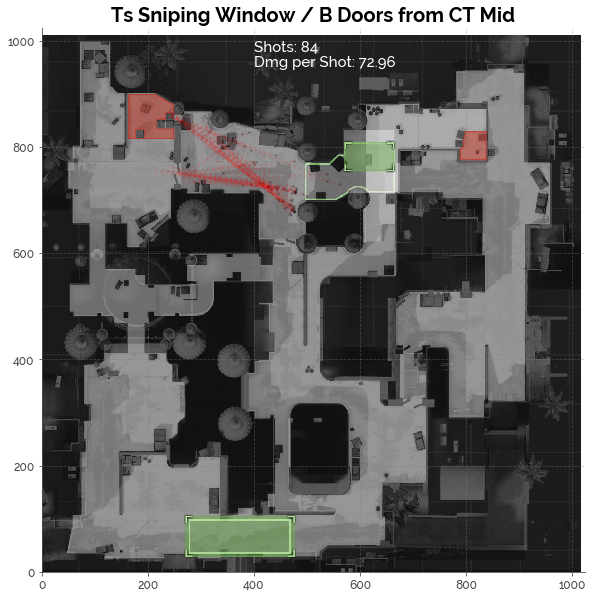

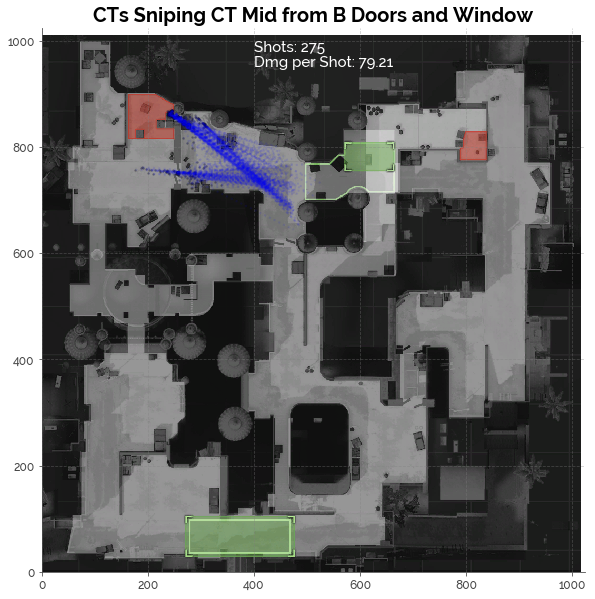

In [31]:
plot_cluster([2], awpt_btm, 'Ts Sniping Window / B Doors from CT Mid', 'red')
plot_cluster([0,3], awpct_btm, 'CTs Sniping CT Mid from B Doors and Window', 'blue')

In [32]:
# Consolidate angles
all_angles = [
    'T Spawn vs. CT Mid', 'Mid vs. CT Mid',
    'Long Doors vs. Long', 'Long vs. A', 'Cross vs. CT Mid',
    'Catwalk and Short Stairs', 'Short vs. A', 'Tunnels Exit vs. Back Plat',
    'Tunnels Exit vs. B', 'CT Mid vs. B'
]

# Consolidate clusters
t_clusters = [[2,11], 17, 7, 4, 10, [0,1], 16, 15, 1, 2]
ct_clusters = [3, [1,8], 7, [0,14], 13, 0, [12,15], 2, 11, [0,3]]

# Initialise list
results = []

# Compute stats
for i in range(len(all_angles)):
    
    # Set up dictionary
    temp_dict = dict()
    
    # Get clusters
    t_clust = t_clusters[i]
    ct_clust = ct_clusters[i]
    
    # Convert to list
    if type(t_clust) != list:
        t_clust = [t_clust]
        
    if type(ct_clust) != list:
        ct_clust = [ct_clust]
    
    # Subset data
    if i == 5:
        t_dat = awpt_css[awpt_css.cluster.isin(t_clust)]
        ct_dat = awpct_css[awpct_css.cluster.isin(ct_clust)]
    
    elif i == 9:
        t_dat = awpt_btm[awpt_btm.cluster.isin(t_clust)]
        ct_dat = awpct_btm[awpct_btm.cluster.isin(ct_clust)]
    
    else:
        t_dat = awpt[awpt.cluster.isin(t_clust)]
        ct_dat = awpct[awpct.cluster.isin(ct_clust)]
    
    # Add angle
    temp_dict['angle'] = all_angles[i]
    
    # Add shot counts
    temp_dict['t_shots'] = t_dat.shape[0]
    temp_dict['ct_shots'] = ct_dat.shape[0]
    
    # Add avg damage
    temp_dict['t_dmg'] = t_dat.hp_dmg.mean()
    temp_dict['ct_dmg'] = ct_dat.hp_dmg.mean()
    
    # Add Mann Whitney U test with less and greater-than alternatives
    _, temp_dict['p_lt'] = mannwhitneyu(t_dat.hp_dmg, ct_dat.hp_dmg, alternative='less')
    _, temp_dict['p_gt'] = mannwhitneyu(t_dat.hp_dmg, ct_dat.hp_dmg, alternative='greater')
    
    # Append
    results.append(temp_dict)
    
# Convert to dataframe
res_df = pd.DataFrame(results)

# Compute shot ratio
res_df['max_shots'] = res_df[['ct_shots', 't_shots']].max(axis=1)
res_df['min_shots'] = res_df[['ct_shots', 't_shots']].min(axis=1)
res_df['shot_ratio'] = res_df.max_shots / res_df.min_shots - 1

# Compute team with positional advantage
mask = (res_df.ct_shots > res_df.t_shots)
res_df['pos_adv'] = np.nan
res_df['pos_adv'][mask] = 'CT'
res_df['pos_adv'][~mask] = 'T'

# Present Positional Advantage
res_df['Positional Advantage'] = res_df['pos_adv'].astype(str) + ' (+' + round(res_df.shot_ratio*100, 0).astype(str) +\
    '%)'

# Compute damage difference
res_df['max_dmg'] = res_df[['ct_dmg', 't_dmg']].max(axis=1)
res_df['min_dmg'] = res_df[['ct_dmg', 't_dmg']].min(axis=1)
res_df['dmg_diff'] = res_df.max_dmg - res_df.min_dmg

# Compute statistically greater damage
res_df['t_eff'] = res_df.p_gt < 0.05
res_df['ct_eff'] = res_df.p_lt < 0.05

# Present Effectiveness Advantage
res_df['eff_adv'] = np.nan
res_df['eff_adv'][res_df.t_eff] = 'T (+' + round(res_df.dmg_diff[res_df.t_eff], 2).astype(str) + ' DMG)'
res_df['eff_adv'][res_df.ct_eff] = 'CT (+' + round(res_df.dmg_diff[res_df.ct_eff], 2).astype(str) + ' DMG)'
res_df['eff_adv'][(~res_df.t_eff) & (~res_df.ct_eff)] = 'Neither'

# Compute CT advantages
res_df['ct_pos_adv'] = (res_df.ct_shots / res_df.t_shots - 1) * 100
res_df['ct_eff_adv'] = res_df.ct_dmg - res_df.t_dmg
res_df['ct_eff_adv'] = (res_df.ct_eff_adv * (res_df.ct_eff).astype(int) + res_df.ct_eff_adv * (res_df.t_eff).astype(int)).astype(float)

# Conclusion [TLDR]
In this post, we analysed various AWP angles on Dust2. We used two metrics: (1) Effectiveness, measured by the average damage of shots in each cluster, and (2) Positional Advantage, measured by the relative shot count amongst clusters. The graph below summarises the findings for each angle that we analysed.

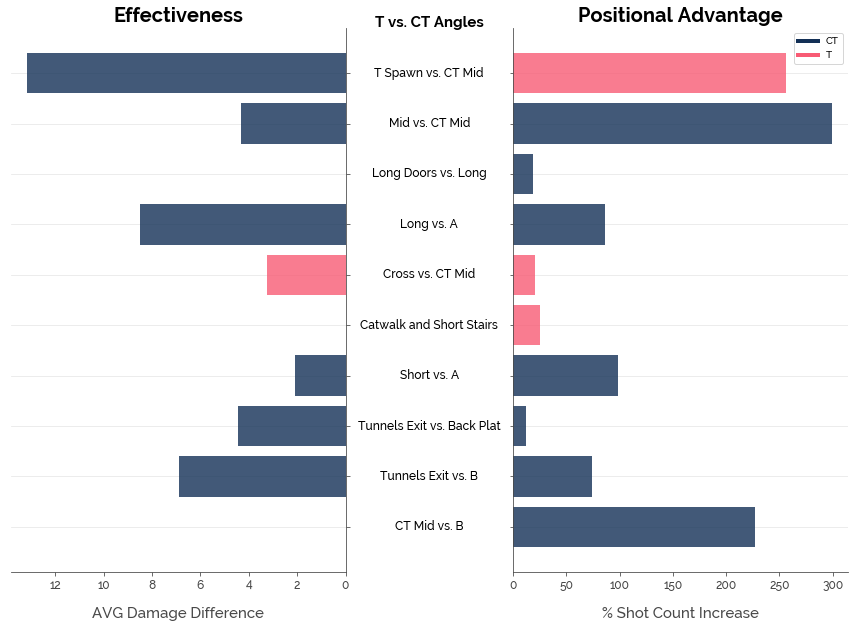

In [33]:
# Pull data
plot_data = res_df[::-1].copy()
plot_data['dmg_diff'] = (plot_data.dmg_diff * (plot_data.ct_eff).astype(int) + plot_data.dmg_diff * (plot_data.t_eff).astype(int)).astype(float)

# Plot
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))

# Configure Effectiveness plot
ax[0].barh(np.arange(0, len(plot_data.angle)), plot_data.dmg_diff, align='center',
           color=['#133056' * (x > 0) + '#f85b74' * (x <= 0) for x in plot_data.ct_eff_adv], alpha=0.8)
ax[0].set_title('Effectiveness', fontdict=fontdict)
ax[0].set_xlabel('AVG Damage Difference', weight='medium')
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(True)
ax[0].invert_xaxis()
ax[0].yaxis.tick_right()

# Configure Positional Advantage Plot
ax[1].barh(np.arange(0, len(plot_data.angle)), plot_data.shot_ratio*100, align='center',
           color=['#133056' * (x > 0) + '#f85b74' * (x < 0) for x in plot_data.ct_pos_adv], alpha=0.8)
ax[1].set_title('Positional Advantage', fontdict=fontdict)
ax[1].set_xlabel('% Shot Count Increase', weight='medium')

# Prepare y-axis labels
fig.subplots_adjust(wspace=0.5)
ax[0].set(yticks=np.arange(0, len(plot_data.angle)), yticklabels=[])
for yloc, angle in zip(np.arange(0, len(plot_data.angle)), plot_data.angle):
    ax[0].annotate(angle, (0.5, yloc), xycoords=('figure fraction', 'data'),
                     ha='center', va='center', size=12)

ax[0].annotate('T vs. CT Angles',(0.5, 10), xycoords=('figure fraction', 'data'),
              ha='center', va='center', size=15, weight='bold')
# Create legend
custom_bars = [Line2D([0], [0], color='#133056', lw=4),
                Line2D([0], [0], color='#f85b74', lw=4)]
ax[1].legend(custom_bars, ['CT', 'T'], loc=0)

# Show
plt.show()

Overall, the CTs appear to have the upper hand for AWP angles. This is interesting, because we know from [my first post in this series](https://chrischow.github.io/dataandstuff/2019-04-06-csgo-analytics-part-1-the-dust2-round/) that Dust 2 is a **T-sided map**. Hence, we must dig further by analysing the shot data for the two most commonly-used rifles in CS:GO - the AK47 and M4A1/M4A4.  